In [1]:
from fastai import*
from fastai.vision import *

In [2]:
torch.cuda.set_device(3)

In [49]:
bs=128

In [26]:
folder='black'
file='urls_black.txt'

In [30]:
folder='teddys'
file='urls_teddys.txt'

In [34]:
folder='grizzly'
file='urls_grizzly.txt'

In [35]:
path=Path('data1/bears')
dest=path/folder
dest.mkdir(parents=True,exist_ok=True)

In [36]:
classes=['teddys','grizzly','black']

In [37]:
download_images(path/file,dest,max_pics=200)

In [38]:
for c in classes:
    print(c)
    verify_images(path/c,delete=True,max_workers=8)

In [50]:
np.random.seed(42)
data=ImageDataBunch.from_folder(path,train=".",valid_pct=0.2,ds_tfms=get_transforms(),size=224,bs=bs,num_workers=8).normalize(imagenet_stats)

In [51]:
data.classes

['black', 'grizzly', 'teddys']

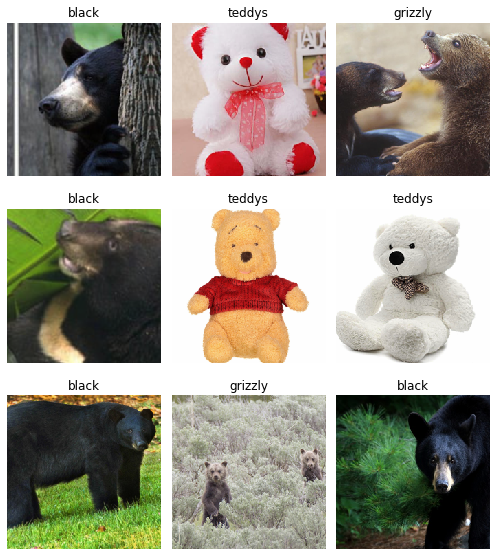

In [52]:
data.show_batch(rows=3,figsize=(7,8))

In [53]:
data.classes,data.c,len(data.train_ds),len(data.valid_ds) #classes,how many possible classes, number of initial images, valid images

(['black', 'grizzly', 'teddys'], 3, 484, 121)

In [54]:
learn=cnn_learner(data,models.resnet34,metrics=error_rate)

In [55]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.321788,0.685715,0.214876,00:14
1,0.942179,0.773163,0.132231,00:13
2,0.846136,0.787709,0.132231,00:13
3,0.749819,0.762663,0.132231,00:14


In [56]:
learn.save('stage-1')

In [57]:
learn.unfreeze()

In [58]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


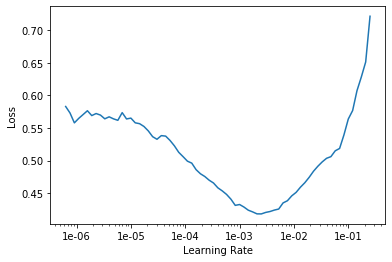

In [59]:
learn.recorder.plot()

In [64]:
learn.fit_one_cycle(8,max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.236050,1.000167,0.198347,00:13
1,0.226394,0.991530,0.206612,00:14
2,0.225489,1.020521,0.223141,00:14
3,0.211484,1.019912,0.223141,00:14
4,0.214009,0.993102,0.198347,00:13
5,0.210307,1.021504,0.190083,00:14
6,0.204974,1.029725,0.198347,00:14
7,0.201331,1.001366,0.190083,00:14


In [65]:
learn.save('stage-2')

### Interpretation

In [67]:
learn.load('stage-2');

In [68]:
interp=ClassificationInterpretation.from_learner(learn)

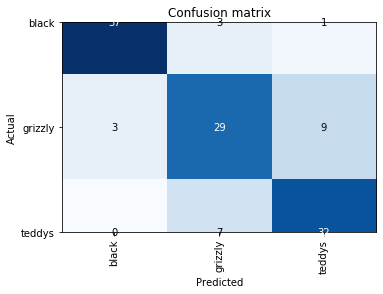

In [69]:
interp.plot_confusion_matrix()

### Cleaning Up the Dataset

In [78]:
from fastai.widgets import*
db=(ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(),size=224)
                   .databunch())

In [81]:
learn_cln=cnn_learner(db,models.resnet34,metrics=error_rate)
learn_cln.load('stage-2');

In [82]:
ds,idxs=DatasetFormatter().from_toplosses(learn_cln)

In [90]:
ImageCleaner(ds,idxs,path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [91]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [92]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### Putting your mdoel in production

In [94]:
learn.export()

In [95]:
defaults.device=torch.device('cpu')

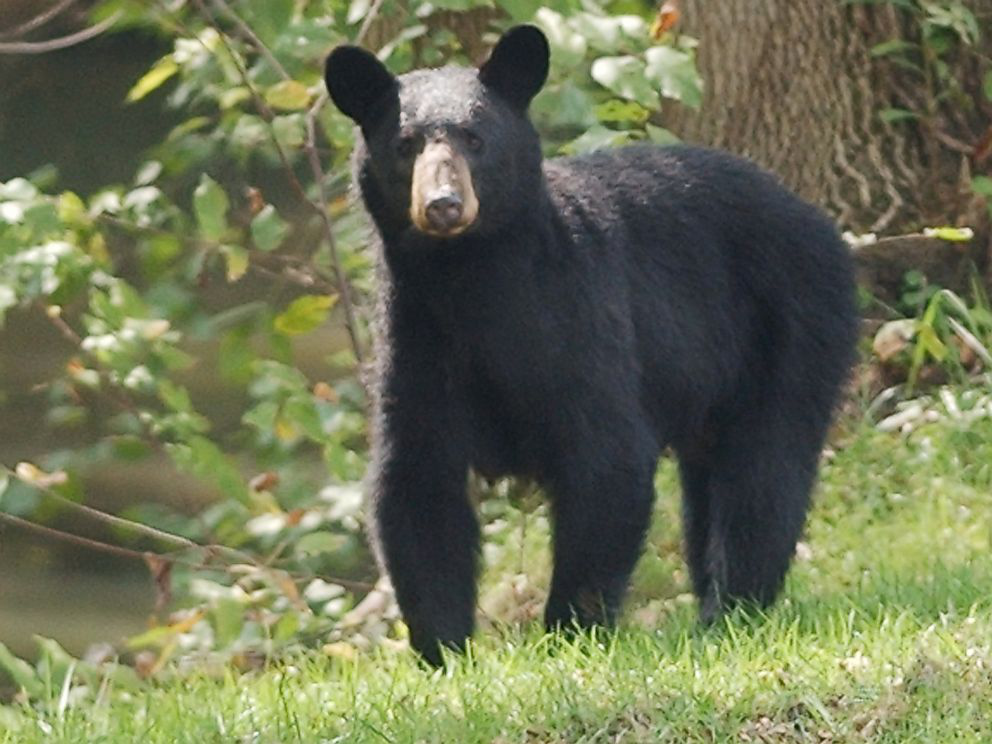

In [97]:
img=open_image(path/'black'/'00000021.jpg')
img

In [98]:
learn=load_learner(path)

In [101]:
pred_class,pred_idx,outputs=learn.predict(img)

In [105]:
pred_class

Category black

### Turning classifier a website
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })